In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import os

In [129]:
def file_path(filename):
    return os.path.join("../../data/clean", filename)

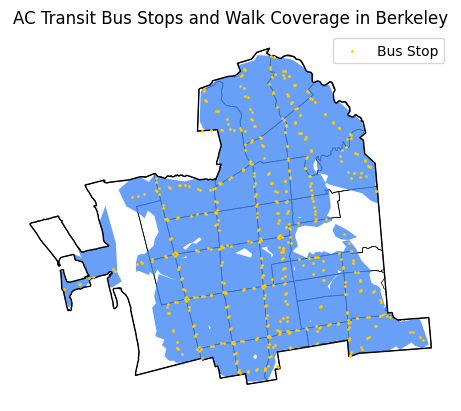

In [84]:
berkeley_boundary = gpd.read_file(
    file_path("berkeley_boundary.geojson")
)
berkeley_tracts = gpd.read_file(
    file_path("berkeley_tracts.geojson")
)
berkeley_tracts = gpd.clip(berkeley_tracts, berkeley_boundary)
berkeley_stops = gpd.read_file(
    file_path("berkeley_stops.geojson")
)
coverage = gpd.read_file(
    file_path("coverage.geojson")
)

fig, ax = plt.subplots()

berkeley_tracts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
coverage.plot(ax=ax, color="#4287f5", alpha=0.8)
berkeley_boundary.plot(ax=ax, color="none", edgecolor="black")
berkeley_stops.plot(ax=ax, markersize=1, color="#ffcc00", label="Bus Stop")

ax.set_title("AC Transit Bus Stops and Walk Coverage in Berkeley")
ax.set_axis_off()

plt.legend()
plt.show()

In [127]:
time_order = [
    "Overnight (1–4:59)",
    "Early AM (5–6:59)",
    "AM Peak (7–9:59)",
    "Midday (10–14:59)",
    "PM Peak (15–18:59)",
    "Evening (19–21:59)",
    "Late Night (22–0:59)",
]

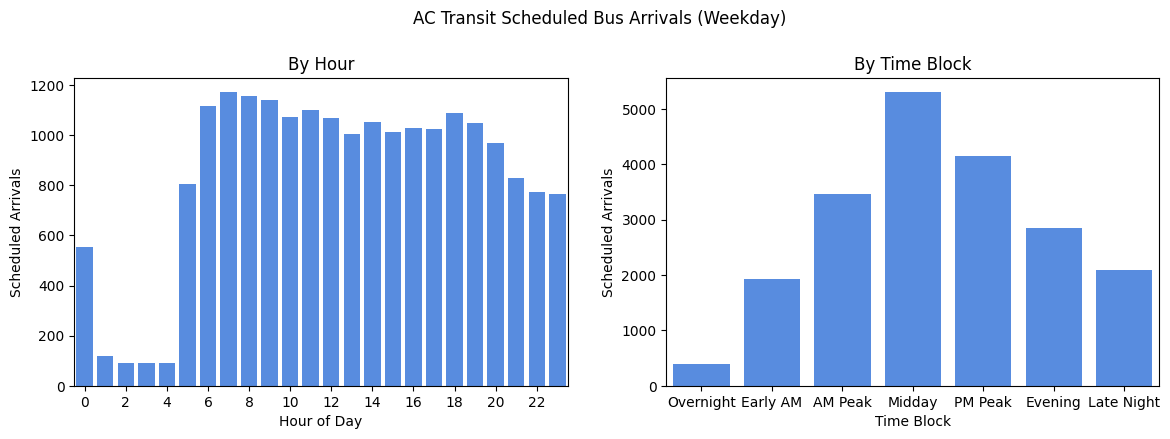

In [126]:
hourly_arrivals = pd.read_csv(
    file_path("hourly_arrivals.csv")
)
time_block_arrivals = pd.read_csv(
    file_path("time_block_arrivals.csv")
)

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
fig.suptitle("AC Transit Scheduled Bus Arrivals (Weekday)", y=1.05)

sns.barplot(
    data=hourly_arrivals,
    x="hour",
    y="arrivals",
    color="#4287f5",
    ax=axes[0]
)

axes[0].set_xticks(range(0, 24, 2))
axes[0].set_title("By Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Scheduled Arrivals")

sns.barplot(
    data=time_block_arrivals,
    x="time_block",
    y="arrivals",
    color="#4287f5",
    order=time_order,
    ax=axes[1]
)

time_block_labels = [
    "Overnight",
    "Early AM",
    "AM Peak",
    "Midday",
    "PM Peak",
    "Evening",
    "Late Night",
]

axes[1].set_xticks(range(len(time_block_labels)))
axes[1].set_xticklabels(time_block_labels)

axes[1].set_title("By Time Block")
axes[1].set_xlabel("Time Block")
axes[1].set_ylabel("Scheduled Arrivals")

plt.show()

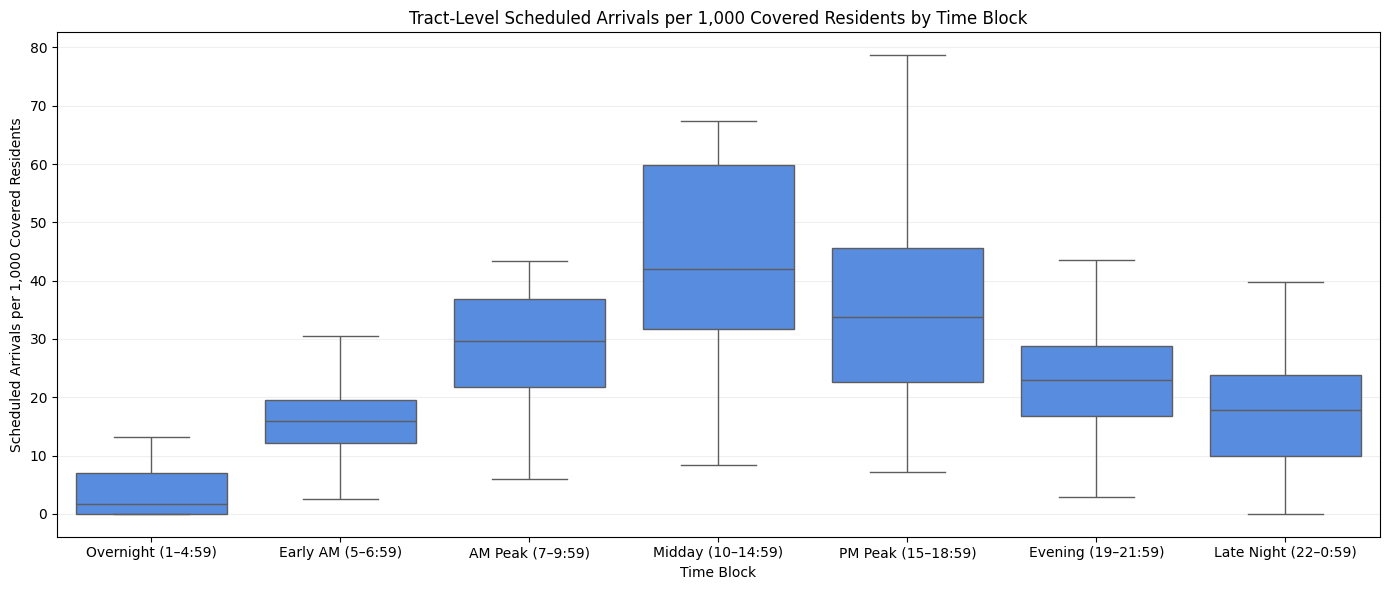

In [153]:
tract_time_block_arrivals = gpd.read_file(
    file_path("tract_time_block_arrivals.geojson")
)

plt.figure(figsize=(14, 6))

ax = sns.boxplot(
    data=tract_time_block_arrivals,
    x="time_block",
    y="arrivals_per_1000_covered",
    order=time_order,
    showfliers=False,
    color="#4287f5",
)

ax.set_xlabel("Time Block")
ax.set_ylabel("Scheduled Arrivals per 1,000 Covered Residents")
ax.set_title("Tract-Level Scheduled Arrivals per 1,000 Covered Residents by Time Block")

ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()